In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")

# load LLM, Embedding

In [33]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings,ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model= "gemini-2.5-pro", 
    temperature=0.2,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    google_api_key=GOOGLE_API_KEY
)
embedding = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

# Load URL, split chunks, vectorstore

In [34]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS

In [35]:
urls=[
    "https://fpt.ai/vi/bai-viet/agentic-ai/",
    "https://fpt-is.com/goc-nhin-so/agentic-ai-la-gi/"
]
docs=[WebBaseLoader(url).load() for url in urls]

In [36]:
docs

[[Document(metadata={'source': 'https://fpt.ai/vi/bai-viet/agentic-ai/', 'title': 'Agentic AI Là Gì? Cách Thức Hoạt động Tự Chủ Của Agentic AI', 'description': 'Khám phá Agentic AI – trí tuệ nhân tạo chủ động, có khả năng ra quyết định và hành động độc lập. Công nghệ đang định hình tương lai ngành AI.', 'language': 'vi'}, page_content='\n\n\n\n\n\n\n\n\n\n\n\n\nAgentic AI Là Gì? Cách Thức Hoạt động Tự Chủ Của Agentic AI\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\nChuyển đến phần nội dung\n\n\n\n\n\n\n\nVề FPT.AI\n\n\n\n\n\n\n\n\n\n\nGiới Thiệu\n\n\n\n\nLiên Hệ\n\n\n\n\n\n\n\nTài liệu\n\n\n\n\n\n\n\n\n\n\n\n\n\nTin tức\n\n\n\n\n\n\n\n\n\n\nSự kiện\n\n\n\n\nTin tức\n\n\n\n\nCơ hội nghề nghiệp\n\n\n\n\n\n\n\nLiên hệ\n\n\n\n\n\n\n\n\n\n\n\n\n\nSự kiện\n\n\n\n\n\n\n\n\n\n\n\n\n\nCơ hội nghề nghiệp\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nvi\n\n\n\n\n\n\n\n\n\n\n\n\n\n vi\n\n\n\n\n en\n\n\n\n\n ja\n\n\n\n\n\n\n\n\n\n

In [37]:
text_split=RecursiveCharacterTextSplitter(
    chunk_size=700,
    chunk_overlap=50
)

In [38]:
doc_list=[
    doc
    for group in docs
    for doc in group
]
doc_split=text_split.split_documents(doc_list)
doc_split

[Document(metadata={'source': 'https://fpt.ai/vi/bai-viet/agentic-ai/', 'title': 'Agentic AI Là Gì? Cách Thức Hoạt động Tự Chủ Của Agentic AI', 'description': 'Khám phá Agentic AI – trí tuệ nhân tạo chủ động, có khả năng ra quyết định và hành động độc lập. Công nghệ đang định hình tương lai ngành AI.', 'language': 'vi'}, page_content='Agentic AI Là Gì? Cách Thức Hoạt động Tự Chủ Của Agentic AI\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\nChuyển đến phần nội dung\n\n\n\n\n\n\n\nVề FPT.AI\n\n\n\n\n\n\n\n\n\n\nGiới Thiệu\n\n\n\n\nLiên Hệ\n\n\n\n\n\n\n\nTài liệu\n\n\n\n\n\n\n\n\n\n\n\n\n\nTin tức\n\n\n\n\n\n\n\n\n\n\nSự kiện\n\n\n\n\nTin tức\n\n\n\n\nCơ hội nghề nghiệp\n\n\n\n\n\n\n\nLiên hệ\n\n\n\n\n\n\n\n\n\n\n\n\n\nSự kiện\n\n\n\n\n\n\n\n\n\n\n\n\n\nCơ hội nghề nghiệp\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nvi\n\n\n\n\n\n\n\n\n\n\n\n\n\n vi\n\n\n\n\n en\n\n\n\n\n ja\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\

In [39]:
vectorstore=FAISS.from_documents(doc_split,embedding)
retriever=vectorstore.as_retriever()        

# Build LLM

In [40]:
from pydantic import BaseModel,Field
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

## Route Query

In [41]:
class RouteQuery(BaseModel):
    datasource: Literal["vectorstore", "web_search"] = Field(
        description="Dựa trên câu hỏi của người dùng, hãy chọn định tuyến đến tìm kiếm vector (vectorstore) hoặc tìm kiếm web (web_search)."
    )

structured_llm_router=llm.with_structured_output(RouteQuery)

In [42]:
system = """Bạn là một chuyên gia tài chính có nhiệm vụ định tuyến câu hỏi của người dùng đến đúng nguồn dữ liệu.

1. **Vectorstore**:
   - Chứa dữ liệu thu thập từ các trang tin AI Agent uy tín tại Việt Nam:

   - Sử dụng công cụ này cho các câu hỏi về:
     - Tin tức công nghệ
     - Doanh nghiệp công nghệ
     - AI Agent
     
2. **Web Search**:
   - Sử dụng khi câu hỏi:
     - Mang tính cập nhật rất mới
     - Không nằm trong dữ liệu đã thu thập
     - Hoặc không liên quan đến AI Agent

Nguyên tắc:
- Nếu câu hỏi có thể trả lời từ dữ liệu đã thu thập đã có → chọn **vectorstore**
- Nếu không → chọn **web_search**
"""

In [43]:
route_prompt=ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
    
)
question_router=route_prompt | structured_llm_router

## Grade Document

In [44]:
class GradeDocuments(BaseModel):
    binary_score: Literal["yes","no"] = Field(
        description="Tài liệu có liên quan đến câu hỏi hay không, 'yes' hoặc 'no'"
    )

In [45]:
structured_llm_grader=llm.with_structured_output(GradeDocuments)

system = """Bạn là một người chấm điểm đánh giá mức độ liên quan của tài liệu được truy xuất đối với câu hỏi của người dùng.
Nếu tài liệu chứa (các) từ khóa hoặc ý nghĩa ngữ nghĩa liên quan đến câu hỏi của người dùng, hãy xếp loại là có liên quan.
Đây không cần phải là một bài kiểm tra quá khắt khe. Mục tiêu là để loại bỏ các kết quả truy xuất sai sót.
Đưa ra điểm số nhị phân 'có' hoặc 'không' để cho biết tài liệu có liên quan đến câu hỏi hay không."""

# Thiết lập Prompt Template cho Grader
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Tài liệu được truy xuất: \n\n {document} \n\n Câu hỏi của người dùng: {question}"),
    ]
)

retrieval_grader=grade_prompt | structured_llm_grader

In [46]:
question = "AI agentic là gì?"
docs=retriever.invoke(question)
docs

[Document(id='e8a23d5a-0735-47cf-872d-3fff5274290e', metadata={'source': 'https://fpt.ai/vi/bai-viet/agentic-ai/', 'title': 'Agentic AI Là Gì? Cách Thức Hoạt động Tự Chủ Của Agentic AI', 'description': 'Khám phá Agentic AI – trí tuệ nhân tạo chủ động, có khả năng ra quyết định và hành động độc lập. Công nghệ đang định hình tương lai ngành AI.', 'language': 'vi'}, page_content='Chính nhờ khả năng vận hành độc lập, ra quyết định có mục tiêu và thích ứng với môi trường, Agentic AI đang trở thành bước tiến lớn tiếp theo trong hành trình phát triển AI, nơi mà trí tuệ nhân tạo không còn là công cụ, mà đang dần trở thành đối tác đồng hành thông minh của con người trong sản xuất, vận hành và đổi mới doanh nghiệp.\nAgentic AI là gì?\n>>> XEM NGAY: AI Agents là gì? Lợi ích và ứng dụng thực tế của AI Agent\nAgentic AI hoạt động như thế nào?'),
 Document(id='74c23ec5-b35c-442a-9f67-108deb245b8f', metadata={'source': 'https://fpt.ai/vi/bai-viet/agentic-ai/', 'title': 'Agentic AI Là Gì? Cách Thức Ho

In [47]:
for doc in docs:
    print(retrieval_grader.invoke({"question":question, "document":doc}))

binary_score='yes'
binary_score='yes'
binary_score='yes'
binary_score='yes'


## Generation

In [48]:
prompt = ChatPromptTemplate.from_template("""
Bạn là một trợ lý AI chuyên trả lời câu hỏi dựa trên ngữ cảnh được cung cấp.

Chỉ sử dụng thông tin trong Context để trả lời.
Nếu không có thông tin, hãy nói rằng bạn không biết.

Context:
{context}

Question:
{question}

Answer:
""")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

context=format_docs(docs)
rag_chain=prompt | llm | StrOutputParser()

generation = rag_chain.invoke({"context": context, "question": question})

In [49]:
generation

'Dựa trên thông tin được cung cấp, Agentic AI được định nghĩa như sau:\n\nAgentic AI là một hệ thống có khả năng chủ động, tự chủ mục tiêu, tự ra quyết định và hành động dựa trên bối cảnh, môi trường thay vì chỉ phản hồi thụ động theo lệnh của con người. Nó đại diện cho thế hệ AI có thể “cảm nhận – suy luận – hành động – học hỏi” (Perceive – Reason – Act – Learn), tạo ra chu trình phản xạ linh hoạt và có tính tự chủ cao.\n\nNgoài ra, Agentic AI còn có kỹ năng giao tiếp tốt, có thể xử lý ngôn ngữ tự nhiên, thảo luận các nhiệm vụ và thể hiện một mức độ lý luận trong việc ra quyết định.'

## Grade Hallucinations

In [50]:
class GradeHallucinations(BaseModel):

    binary_score: Literal["yes","no"]= Field(
        description="Câu trả lời có dựa trên sự thật hay không, 'yes' hoặc 'no'"
    )

structured_llm_grader = llm.with_structured_output(GradeHallucinations)

system = """Bạn là một người chấm điểm đánh giá xem nội dung do LLM tạo ra có dựa trên hoặc được hỗ trợ bởi một tập hợp các sự thật đã được truy xuất hay không.
Hãy đưa ra điểm nhị phân 'yes' hoặc 'no'. 'Yes' có nghĩa là câu trả lời có cơ sở hoặc được hỗ trợ bởi tập hợp các sự thật đó."""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Tập hợp các sự thật: \n\n {documents} \n\n Nội dung LLM tạo ra: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader

hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

## Grade Answer

In [51]:
class GradeAnswer(BaseModel):
    binary_score: Literal["yes","no"] = Field(
        description="Câu trả lời có giải quyết được câu hỏi hay không, 'yes' hoặc 'no'"
    )

structured_llm_grader = llm.with_structured_output(GradeAnswer)

system = """Bạn là một người chấm điểm đánh giá xem một câu trả lời có giải quyết / xử lý được một câu hỏi hay không.
Hãy đưa ra điểm nhị phân 'yes' hoặc 'no'. 'Yes' có nghĩa là câu trả lời đó giải quyết được câu hỏi."""

answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Câu hỏi người dùng: \n\n {question} \n\n Nội dung LLM tạo ra: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader

answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

## question rewrite

In [52]:
system = """Bạn là một người viết lại câu hỏi, chuyên chuyển đổi câu hỏi đầu vào thành một phiên bản tốt hơn được tối ưu hóa cho việc truy xuất từ vectorstore.
Hãy nhìn vào câu hỏi đầu vào và cố gắng suy luận về ý định / ý nghĩa ngữ nghĩa tiềm ẩn bên dưới."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Đây là câu hỏi ban đầu: \n\n {question} \n Hãy đặt lại một câu hỏi đã được cải thiện.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question":question})

'Chắc chắn rồi. Đây là cách tôi sẽ viết lại câu hỏi để tối ưu hóa cho việc truy xuất từ vectorstore.\n\n### Câu hỏi được cải thiện:\n\n**Giải thích khái niệm AI agentic (AI có tính tác tử), bao gồm các đặc điểm chính như khả năng tự chủ, lập kế hoạch, và thực hiện một chuỗi hành động để đạt được mục tiêu. So sánh sự khác biệt giữa AI agentic và các mô hình ngôn ngữ lớn (LLM) thông thường.**\n\n---\n\n### Phân tích tại sao câu hỏi này tốt hơn:\n\nCâu hỏi ban đầu "AI agentic là gì?" khá ngắn gọn và có thể chỉ trả về một định nghĩa cơ bản. Câu hỏi được cải thiện tốt hơn vì:\n\n1.  **Giàu ngữ nghĩa hơn:** Nó không chỉ hỏi "là gì" mà còn gợi ý các từ khóa và khái niệm liên quan mật thiết như "tính tác tử", "tự chủ", "lập kế hoạch", "chuỗi hành động", "đạt được mục tiêu". Điều này giúp vector search tìm thấy những đoạn văn bản giải thích sâu sắc về bản chất của AI agentic.\n2.  **Xác định rõ ý định:** Câu hỏi thể hiện rõ người dùng không chỉ muốn một định nghĩa, mà còn muốn hiểu các đặc tính

## Search web

In [53]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3,tavily_api_key=TAVILY_API_KEY)

C:\Users\Khang\AppData\Local\Temp\ipykernel_19560\380992419.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3,tavily_api_key=TAVILY_API_KEY)


# Build Node

In [54]:
from typing_extensions import TypedDict,List
from langchain_core.documents import Document

In [ ]:
class GraphState(TypedDict):
    question: str
    generation: str
    documents: List[Document]

In [56]:
def retrieve(state:GraphState):
    documents=retriever.invoke(state['question'])
    
    return {"documents":documents}

In [ ]:
def generate(state):
    
    context = format_docs(state["documents"])
    generation = rag_chain.invoke(
        {"context": context, "question": state["question"]}
    )

    return {"generation": generation}

In [ ]:
def grade_documents(state:GraphState):
    documents=state['documents']

    filtered_docs=[]
    for document in documents:
        score = retrieval_grader.invoke(
            {
                "document": document.page_content,
                "question": state["question"],
            }
        )
        if score.binary_score=="yes":
            filtered_docs.append(document)
    
    return {"documents":filtered_docs}
        

In [59]:
def transform_query(state):

    better_question = question_rewriter.invoke({"question": state["question"]})

    return { "question": better_question}

In [ ]:
def web_search(state):

    print("---WEB SEARCH---")
    question = state["question"]

    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": [web_results], "question": question}

In [61]:
def route_question(state):

    question = state["question"]
    source = question_router.invoke({"question": question})
    
    if source.datasource == "web_search":
        return "web_search"
    elif source.datasource == "vectorstore":
        return "vectorstore"

In [62]:
def decide_to_generate(state):

    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        return "transform_query"
    else:
        return "generate"

In [63]:
def grade_generation_v_documents_and_question(state):

    score = hallucination_grader.invoke(
        {"documents": state["documents"], "generation": state["generation"]}
    )
    grade = score.binary_score

    if grade == "yes":
        score = answer_grader.invoke({"question": state["question"], "generation": state["generation"]})
        grade = score.binary_score
        if grade == "yes":
            return "useful"
        else:
            return "not useful"
        
    else:
        return "not supported"

# Build Graph

In [64]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

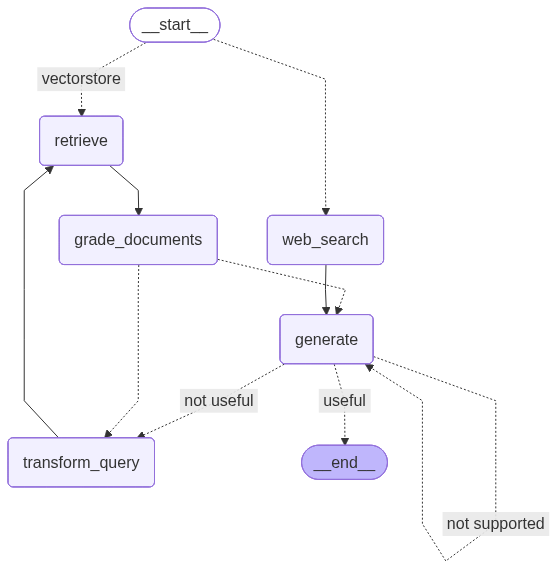

In [65]:
app